# Data loading & cleaning

In [199]:
import pandas
allData = pandas.read_csv('readyData.csv')
allData.head()

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_montly_hours_norm,time_spend_company_norm,Work_accident,promotion_last_5years,salary_num,sales_num,label
0,0,0.38,0.53,2,-0.205843,-0.062279,0,0,1,8,1
1,1,0.80,0.86,5,0.284812,0.312721,0,0,2,8,1
2,2,0.11,0.88,7,0.331540,0.062721,0,0,2,8,1
3,3,0.72,0.87,5,0.102569,0.187721,0,0,1,8,1
4,4,0.37,0.52,2,-0.196497,-0.062279,0,0,1,8,1


In [200]:
del allData['Unnamed: 0']
allData.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours_norm,time_spend_company_norm,Work_accident,promotion_last_5years,salary_num,sales_num,label
0,0.38,0.53,2,-0.205843,-0.062279,0,0,1,8,1
1,0.80,0.86,5,0.284812,0.312721,0,0,2,8,1
2,0.11,0.88,7,0.331540,0.062721,0,0,2,8,1
3,0.72,0.87,5,0.102569,0.187721,0,0,1,8,1
4,0.37,0.52,2,-0.196497,-0.062279,0,0,1,8,1


In [201]:
scrambledData = allData.sample(frac=1).reset_index(drop=True)
trainingData = scrambledData[:12000]
testData = scrambledData[12000:]
trainingLabels = trainingData.label
testLabels = testData.label
del trainingData['label']
del testData['label']

## PCA

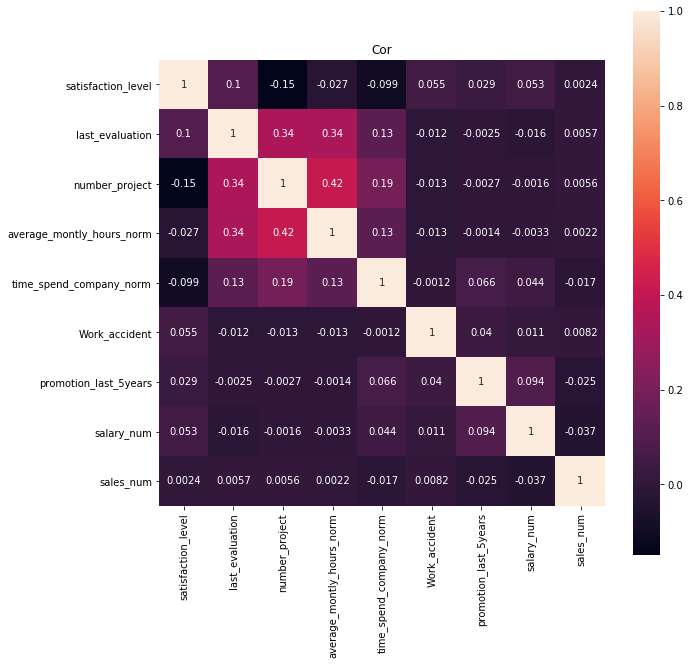

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
cor = pandas.DataFrame(trainingData).corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, vmax=1, square=True,annot=True)

plt.title('Cor')
plt.show()

Any correlation means that the dataset can be reducted in some way.

Variance explained with the first 6 components:  99.2900675039 %


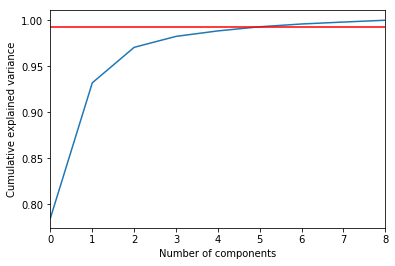

In [203]:
from sklearn.decomposition import PCA
from functools import reduce
pca = PCA().fit(trainingData)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,8,1)
cumSixth = reduce((lambda x, y: x + y), pca.explained_variance_ratio_[:6])
print("Variance explained with the first 6 components: ", cumSixth*100, '%')
plt.axhline(y=cumSixth, color='r', linestyle='-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Cutting off the 7th and 8th components costs about 0.7% of the explained variance to be lost in exchange for removing 1/3 of the data. 

In [204]:
trainingData = PCA(n_components=6).fit_transform(trainingData)
testData = PCA(n_components=6).fit_transform(testData)

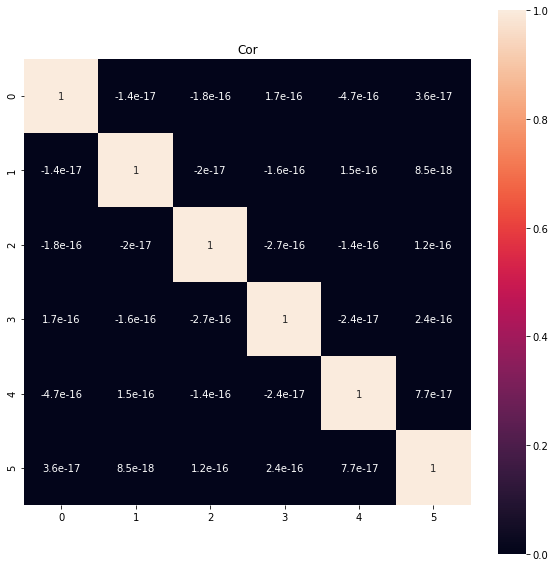

In [205]:
cor = pandas.DataFrame(trainingData).corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, vmax=1, square=True,annot=True)

plt.title('Cor')
plt.show()

Much better, this dataset near its smallest possible reduction. However, the columns have lost their relationship to the original data.

## Create the model 100x100x2

In [206]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.optimizers import SGD

In [207]:
reg = 0.0003

nnModel = Sequential()
nnModel.add(Dense(100, input_shape=(6,), kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("relu"))
nnModel.add(Dense(100, kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("relu"))
nnModel.add(Dense(2, kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("softmax"))
nnModel.summary()
sgd = SGD(lr=0.1, momentum=0.0, decay=0.00001, nesterov=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 100)               700       
_________________________________________________________________
activation_66 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_67 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_68 (Activation)   (None, 2)                 0         
Total params: 11,002
Trainable params: 11,002
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [208]:
import time
import sklearn.metrics
import numpy as np

start = time.time()
nnModel.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
nnModel.fit(np.array(trainingData), to_categorical(trainingLabels), batch_size=32,epochs=20, shuffle=True)


Epoch 1/20
12000/12000 [==============================] - 0s - loss: 0.4016 - categorical_accuracy: 0.8499     
Epoch 2/20
12000/12000 [==============================] - 0s - loss: 0.3049 - categorical_accuracy: 0.8912     
Epoch 3/20
12000/12000 [==============================] - 0s - loss: 0.2921 - categorical_accuracy: 0.8970     
Epoch 4/20
12000/12000 [==============================] - 0s - loss: 0.2822 - categorical_accuracy: 0.9047     
Epoch 5/20
12000/12000 [==============================] - 0s - loss: 0.2763 - categorical_accuracy: 0.9056     
Epoch 6/20
12000/12000 [==============================] - 0s - loss: 0.2750 - categorical_accuracy: 0.9055     
Epoch 7/20
12000/12000 [==============================] - 0s - loss: 0.2724 - categorical_accuracy: 0.9078     
Epoch 8/20
12000/12000 [==============================] - 0s - loss: 0.2707 - categorical_accuracy: 0.9073     
Epoch 9/20
12000/12000 [==============================] - 0s - loss: 0.2696 - categorical_accuracy: 0.90

The learning slows down after about 10 epochs and won't converge any further after about 30 epochs.

## Predict using the model. Best result F-score ~0.8

In [209]:
pred = nnModel.predict_classes(np.array(testData))
end = time.time()
print(end - start)
f1 = sklearn.metrics.f1_score(testLabels, pred)
print ('F1 Score:', f1)

2048/2999 [===================>..........] - ETA: 0s 9.82376766204834
F1 Score: 0.803558191253


I used the F1-score here to catch any bias toward one of the classes.